Успользуем даннае раннего проекта и проанализируем,как дисбаланс классов и методы его выравнивания влияют на основные метрики
и соотношения долей в матрице неточностей.

1.ОПИСАНИЕ ДАННЫХ МАССИВА

Признаки: RowNumber — индекс строки в данных CustomerId — уникальный идентификатор клиента Surname — фамилия CreditScore — кредитный рейтинг Geography — страна проживания Gender — пол Age — возраст Tenure — сколько лет человек является клиентом банка Balance — баланс на счёте NumOfProducts — количество продуктов банка, используемых клиентом HasCrCard — наличие кредитной карты IsActiveMember — активность клиента EstimatedSalary — предполагаемая зарплата

Целевой признак: Exited — факт ухода клиента

Построим и испытаем модели,используя три способа выбора гиперпараметров

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


!pip install optuna
import joblib 
import optuna 
from optuna.samplers import TPESampler


!pip install scikit-plot
import scikitplot as skplt

!pip install lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

!pip install catboost
import catboost
from catboost import Pool,CatBoost
from catboost import CatBoostClassifier
from catboost.utils import eval_metric
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from catboost.utils import select_threshold
from catboost.utils import get_roc_curve
from catboost.utils import get_confusion_matrix

#!pip install imblearn
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
try:
    data = pd.read_csv('/datasets/Churn.csv')
                       
except:
                       
    data = pd.read_csv('C:/Users/анатолий/Documents/datasets/Churn.csv')
data=data.rename(columns=str.lower)#  названия столбцов перевели в строковый    
print(data.shape)    
data.head()


(10000, 14)


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


ИТАК видим 3 признака object фамилия,страна проживания и пол. В столбце с временем продолжительности нахождения в качестве клиента банка 909 пропущенных значений(~ 10% ) и их заполним медианой посмотрим как изменится тип данных.Остальные столбцы int и float. Посмотрим дисбаланс классов .Поработаем с кодированием категориальных признаков

In [3]:
data['geography'].sort_values().value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

In [4]:
data[data['geography'] == 'Germany']['geography'].unique().sum()

'Germany'

In [5]:
data=data.drop(['rownumber','customerid','surname'],axis=1)
data.info()
print(data.dtypes)
data.isna().sum()
display(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB
creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())# заполним пропуски медианой
display(data.head())
print(data.isna().sum())
data.info()
types = pd.DataFrame(data.dtypes)
print('Столбцы с категориальными данными:\n',list(types[types[0] == 'object'].index) )       

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usa

In [7]:
data_ohe = pd.get_dummies(data,drop_first=True)

features = data_ohe.drop(['exited'],axis=1)
target = data_ohe['exited']

# оставим для теста 25% выборки а оставшиеся 75% разобьем на тренировочную и валидационную
features_train,features_test,target_train,target_test =\
                                                     train_test_split(features,target,\
                                                        test_size = 0.25,random_state = 12345,\
                                                                     stratify=target)
print('Размер тренировочной выборки',features_train.shape, target_train.shape)
print('Размер тестовой выборки',features_test.shape, target_test.shape)    # с размерностями ОК

Размер тренировочной выборки (7500, 11) (7500,)
Размер тестовой выборки (2500, 11) (2500,)


In [8]:
%%time

pipe_log=make_pipeline(StandardScaler(),LogisticRegression(random_state=12345))
param_grid = {
              "penalty": ["l1", "l2"],
              "C" :[0.01,0.1,1.0] ,
              "fit_intercept": [True, False],
              
              "solver": ["liblinear", "saga"]
             }

grid = GridSearchCV(LogisticRegression(multi_class="auto", max_iter=10), param_grid, cv=5)
grid = grid.fit(features_train, target_train)
grid.best_params_

Wall time: 9.09 s


{'C': 1.0, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear'}

In [9]:
lgr_classifier = LogisticRegression(**grid.best_params_)
lgr_classifier.fit(features_train,target_train)
pred = lgr_classifier.predict(features_test)

print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1991
           1       0.63      0.22      0.32       509

    accuracy                           0.81      2500
   macro avg       0.73      0.59      0.61      2500
weighted avg       0.79      0.81      0.78      2500



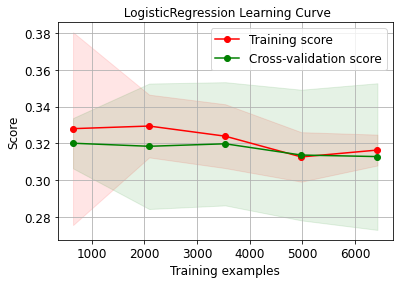

In [10]:
skplt.estimators.plot_learning_curve(lgr_classifier,features_train,target_train ,
                                     cv=7, shuffle=True, scoring="f1",
                                     n_jobs=-1, figsize=(6,4), title_fontsize="large", text_fontsize="large",
                                     title=" LogisticRegression Learning Curve");

ИТАК:
Лучшая мера f1 модели на обучающей выборке:0.32
Лучший параметр регуляризации и пенальти на обучающей выборке: C=10,penalty: 'l2'}
Мера f1 модели LogisticRegression(random_state=12345,C=10,penalty=l2) на valid выборке:0.31
Логистическую регрессию отбросим из рассмотрения в виду малости меры f1.
Кривая проверки для LogisticRegression показывает что размера выборки достаточно,но повысить значение
меры f1 не получится на этой модели.
Параметр С=10 обратной регуляризации дает максимум меры f1 и видим большую погрешность на кривой проверки.
Может модель так и называется потому как здесь прям все логично 

In [11]:
%%time
#          DecisionTreeClassifier

model_dtr = DecisionTreeClassifier()

params_grid = {'max_depth':[1,5,9,13,15]}

grid = GridSearchCV(model_dtr, param_grid=params_grid,cv=3,verbose=1)

dtr_classifier = grid.fit(features_train,target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Wall time: 573 ms


In [12]:
print(dtr_classifier.best_score_)
print(dtr_classifier.best_estimator_.get_params())

0.8548
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


In [13]:
%%time
dtr_classifier =DecisionTreeClassifier(**dtr_classifier.best_params_)# определили модель с лучшими параметрами
dtr_classifier.fit(features_train,target_train)

pred_test = dtr_classifier.predict(features_test)
pred_train = dtr_classifier.predict(features_train)
print(classification_report(target_test, pred_test))

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      1991
           1       0.85      0.36      0.50       509

    accuracy                           0.86      2500
   macro avg       0.85      0.67      0.71      2500
weighted avg       0.86      0.86      0.83      2500

Wall time: 55.8 ms


In [14]:
# выберем гиперпараметры с помощью OPTUNA
def objective(trial):
    # Define the search space
    criterions = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    max_depths = trial.suggest_int('max_depth', 1, 15, 5)
    n_estimators = trial.suggest_categorical('n_estimators', [5,15,55])

    clf = RandomForestClassifier(n_estimators=n_estimators,
                                 criterion=criterions,
                                 max_depth=max_depths,
                                 n_jobs=-1)
    f1 = cross_val_score(clf,features,target,scoring="f1").mean()

    return f1

In [15]:
# созадим объект изучения 
study = optuna.create_study(study_name="randomForest_optimization",
                            direction="maximize",
                            sampler=TPESampler())

[I 2022-10-02 09:52:38,621] A new study created in memory with name: randomForest_optimization


In [16]:
# оптимизация обекта изучения
study.optimize(objective, n_trials=15)

[I 2022-10-02 09:52:39,429] Trial 0 finished with value: 0.07855757226543744 and parameters: {'criterion': 'entropy', 'max_depth': 1, 'n_estimators': 5}. Best is trial 0 with value: 0.07855757226543744.
[I 2022-10-02 09:52:43,168] Trial 1 finished with value: 0.575028067177529 and parameters: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 55}. Best is trial 1 with value: 0.575028067177529.
[I 2022-10-02 09:52:52,405] Trial 2 finished with value: 0.571959907969396 and parameters: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 55}. Best is trial 1 with value: 0.575028067177529.
[I 2022-10-02 09:52:53,086] Trial 3 finished with value: 0.020465116279069766 and parameters: {'criterion': 'gini', 'max_depth': 1, 'n_estimators': 15}. Best is trial 1 with value: 0.575028067177529.
[I 2022-10-02 09:52:57,876] Trial 4 finished with value: 0.5765264500298579 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 55}. Best is trial 4 with value: 0.5765264500298579

In [17]:
print('Метрика f1 выбранной лучшей модели',study.best_value)

Метрика f1 выбранной лучшей модели 0.5765264500298579


In [18]:
print(study.best_params)

{'criterion': 'entropy', 'max_depth': 11, 'n_estimators': 55}


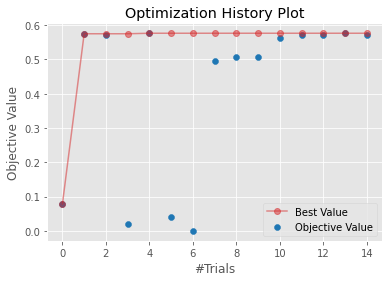

In [19]:
# нарисуем историю оптимизации
optuna.visualization.matplotlib.plot_optimization_history(study);

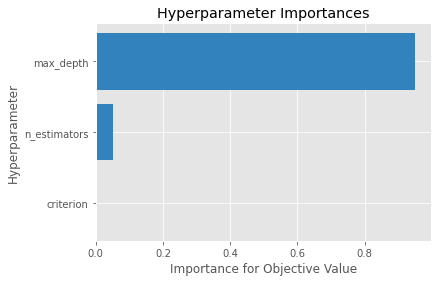

In [20]:
# для этой оптимизации главные параметры
optuna.visualization.matplotlib.plot_param_importances(study);

In [21]:
# таблица процесса оптимизайии
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_n_estimators,state
0,0,0.078558,2022-10-02 09:52:38.656479,2022-10-02 09:52:39.429743,0 days 00:00:00.773264,entropy,1,5,COMPLETE
1,1,0.575028,2022-10-02 09:52:39.446612,2022-10-02 09:52:43.168369,0 days 00:00:03.721757,gini,11,55,COMPLETE
2,2,0.571960,2022-10-02 09:52:43.168369,2022-10-02 09:52:52.405776,0 days 00:00:09.237407,gini,11,55,COMPLETE
3,3,0.020465,2022-10-02 09:52:52.405776,2022-10-02 09:52:53.086083,0 days 00:00:00.680307,gini,1,15,COMPLETE
4,4,0.576526,2022-10-02 09:52:53.086083,2022-10-02 09:52:57.876201,0 days 00:00:04.790118,entropy,11,55,COMPLETE
5,5,0.039830,2022-10-02 09:52:57.876201,2022-10-02 09:52:58.566705,0 days 00:00:00.690504,entropy,1,5,COMPLETE
6,6,0.000000,2022-10-02 09:52:58.571671,2022-10-02 09:53:00.265869,0 days 00:00:01.694198,gini,1,55,COMPLETE
7,7,0.496804,2022-10-02 09:53:00.265869,2022-10-02 09:53:01.120246,0 days 00:00:00.854377,entropy,6,15,COMPLETE
8,8,0.506113,2022-10-02 09:53:01.122232,2022-10-02 09:53:02.090244,0 days 00:00:00.968012,gini,6,15,COMPLETE
9,9,0.508370,2022-10-02 09:53:02.090244,2022-10-02 09:53:05.174757,0 days 00:00:03.084513,entropy,6,55,COMPLETE


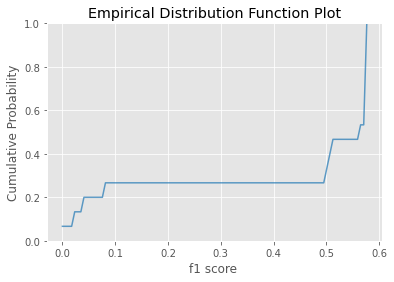

In [22]:
# как происходила тренировка до лучшего результата метрики
optuna.visualization.matplotlib.plot_edf(study, target_name="f1 score ");

In [23]:
%%time
rfc_classifier = RandomForestClassifier(**study.best_params)# cоздание мадели с лучшими параметрами
rfc_classifier.fit(features_train,target_train)
pred_train = rfc_classifier.predict(features_train)
pred_test = rfc_classifier.predict(features_test)
print(classification_report(target_test, pred_test))


              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1991
           1       0.79      0.44      0.57       509

    accuracy                           0.86      2500
   macro avg       0.83      0.71      0.74      2500
weighted avg       0.86      0.86      0.85      2500

Wall time: 1.11 s


Для класса 0 с большим значением в балансе классов метрики больше,чем  для класса 1.
Получается алгоритм хорошо работает на большем количестве данных - очевидно.
Но ниже посмотрим как все проходит на тестовой выборке.


    Борьба с дисбалансом

Распределение меток классов
 0    7963
1    2037
Name: exited, dtype: int64


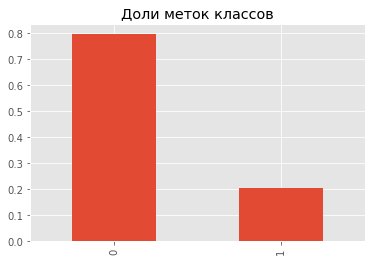

In [24]:
class_frequency = data['exited'].value_counts()
print('Распределение меток классов\n',class_frequency)
target.value_counts(normalize='true').plot(kind='bar',grid=True,title='Доли меток классов');

In [25]:
#         расчет метрик с дисбалансом классов

print('Перед применением метода кол-во меток со значением 1: {}'.format(sum(target_train == True)))
print('Перед применением метода кол-во меток со значением 0: {}'.format(sum(target_train == False)))
model_random = rfc_classifier
model_random.fit(features_train,target_train)
predictions_test_random = model_random.predict(features_test)

print('recall : {:.2f}'.format(recall_score(y_true=target_test,\
                                                                y_pred=predictions_test_random)))
print('precision : {:.2f}'.format(precision_score(y_true=target_test,\
                                                                y_pred=predictions_test_random)))

print('  f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                                y_pred=predictions_test_random)))
print(classification_report(target_test, predictions_test_random))

Перед применением метода кол-во меток со значением 1: 1528
Перед применением метода кол-во меток со значением 0: 5972
recall : 0.45
precision : 0.79
  f1  : 0.58
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1991
           1       0.79      0.45      0.58       509

    accuracy                           0.86      2500
   macro avg       0.83      0.71      0.75      2500
weighted avg       0.86      0.86      0.85      2500



In [26]:
#       Расчет метрик после балансировки классов методом SMOTE(повышение до большего)

smt = SMOTE()
features_train_smote, target_train_smote = smt.fit_resample(features_train, target_train)
print('После применения метода SMOTE кол-во меток со значением 1: {}'.format(sum(target_train_smote == True)))
print('После применения метода SMOTE кол-во меток со значением 0: {}'.format(sum(target_train_smote == False)))
model_smote =  rfc_classifier
model_smote.fit(features_train_smote,target_train_smote)
predictions_smote = model_smote.predict(features_test)
print('recall : {:.2f}'.format(recall_score(y_true=target_test,\
                                                                y_pred=predictions_smote)))
print('precision : {:.2f}'.format(precision_score(y_true=target_test,\
                                                                y_pred=predictions_smote)))
print('   f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                                y_pred=predictions_smote)))
print(classification_report(target_test, predictions_smote))

После применения метода SMOTE кол-во меток со значением 1: 5972
После применения метода SMOTE кол-во меток со значением 0: 5972
recall : 0.63
precision : 0.52
   f1  : 0.57
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1991
           1       0.52      0.63      0.57       509

    accuracy                           0.81      2500
   macro avg       0.71      0.74      0.72      2500
weighted avg       0.82      0.81      0.81      2500



In [27]:
#   Расчет метрик после балансировки классов методом NearMiss(с понижением до меньшего класса)
!pip install imblearn
from imblearn.under_sampling import NearMiss
nm = NearMiss()
features_train_miss, target_train_miss = nm.fit_resample(features_train, target_train)
print('После применения метода NearMiss кол-во меток со значением 1: {}'.format(sum(target_train_miss == True)))
print('После применения метода NearMiss кол-во меток со значением 0: {}'.format(sum(target_train_miss == False)))

model_miss = rfc_classifier
model_miss.fit(features_train_miss,target_train_miss)
predictions_miss = model_miss.predict(features_test)
print('recall : {:.2f}'.format(recall_score(y_true=target_test,\
                                                                y_pred=predictions_miss)))
print('precision : {:.2f}'.format(precision_score(y_true=target_test,\
                                                                y_pred=predictions_miss)))
print('   f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                                y_pred=predictions_miss)))
print()
print(classification_report(target_test, predictions_miss))

После применения метода NearMiss кол-во меток со значением 1: 1528
После применения метода NearMiss кол-во меток со значением 0: 1528
recall : 0.90
precision : 0.26
   f1  : 0.41

              precision    recall  f1-score   support

           0       0.93      0.36      0.52      1991
           1       0.26      0.90      0.41       509

    accuracy                           0.47      2500
   macro avg       0.60      0.63      0.47      2500
weighted avg       0.80      0.47      0.50      2500



При уменьшении размерности f1 заметно уменьшается по двум классам,а метрика полноты recall уменьшилась для класса 0(большего),но выросла для класса 1(меньшего).Метрика точности precision для класса 0 практически не изменилась, а для класса 1 упала вдвое.
Получили:
Уменьшение размерности до меньшего класса приводит к увеличению полноты(доли ТР значений) в этом классе и понижению точности 
в этом меньшем классе - это тоже понятно.

Устранение дисбаланса до размеров большего класса(0) привело к уменьшению метрик в классе 1 по точности и росту полноты recall.
Это важно для предсказаний классов для разных задач классификации.

Далее построим ROC кривые и матрицы неточностей для разных способов балансировки

Постороим ROC кривые в зависимости от способа выравнивания дисбаланса классов

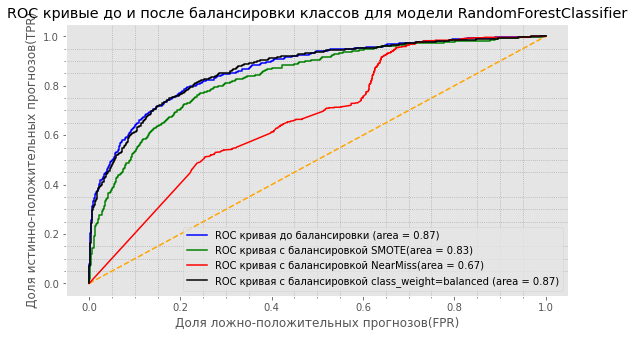

In [28]:
rfc_classifier.fit(features_train, target_train)
lr_probs = rfc_classifier.predict_proba(features_test)# получаем предказания
lr_probs = lr_probs[:, 1]# сохраняем вероятности только для положительного исхода
fpr, tpr, treshold = roc_curve(target_test, lr_probs)
roc_auc = auc(fpr, tpr)

model_smote.fit(features_train_smote,target_train_smote)
lr_probs1 = model_smote.predict_proba(features_test)
lr_probs1 = lr_probs1[:, 1]
fpr1, tpr1, treshold1 = roc_curve(target_test, lr_probs1)
roc_auc = auc(fpr1, tpr1)

model_miss.fit(features_train_miss,target_train_miss)
lr_probs2 = model_miss.predict_proba(features_test)
lr_probs2 = lr_probs2[:, 1]
fpr2, tpr2, treshold2 = roc_curve(target_test, lr_probs2)
roc_auc = auc(fpr2, tpr2)

model_random_balance =RandomForestClassifier(random_state=12345,n_estimators=55,max_depth=11,\
                                             criterion= 'entropy',class_weight='balanced')

model_random_balance.fit(features_train,target_train).predict_proba(features_test)
lr_probs3 = model_random_balance.predict_proba(features_test)
lr_probs3 = lr_probs3[:, 1]
fpr3, tpr3, treshold3 = roc_curve(target_test, lr_probs3)
roc_auc = auc(fpr3, tpr3)


fig=plt.figure(figsize=(9,5))
ax=fig.add_subplot()        
plt.plot([0, 1], [0, 1], color='orange', linestyle='--');
roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
ax.plot(fpr, tpr,color='blue',label='ROC кривая до балансировки (area = %0.2f)' % roc_auc)
ax.plot(fpr1, tpr1, color = 'green',label='ROC кривая с балансировкой SMOTE(area = %0.2f)' % roc_auc1) 
ax.plot(fpr2, tpr2,color='red',label='ROC кривая с балансировкой NearMiss(area = %0.2f)' % roc_auc2)
ax.plot(fpr3, tpr3,color='black',label='ROC кривая с балансировкой class_weight=balanced (area = %0.2f)' % roc_auc3)

plt.xlabel('Доля ложно-положительных прогнозов(FPR)')
plt.ylabel('Доля истинно-положительных прогнозов(TPR)')
plt.minorticks_on()
plt.grid(which='major',color='#333',linewidth=1)#большая сетка 
plt.grid(which='minor',color='#aaa',ls=':')
plt.title('ROC кривые до и после балансировки классов для модели RandomForestClassifier')

plt.legend(loc="best");


Видим,что понижение размерности до меньшего класса в дисбалансе классов уменьшает площадь под ROC кривой,тогда как 
для несбаланированного размера классов и способа class_weight='balanced' площадь почти одинаковая.
SMOTE дает чуть меньшую площадь.
Теперь рассмотрим как влияет балансировка на доли предсказываемых классов.

Матрица неточностей до балансировки классов : [[1932   59]
 [ 283  226]]
До балансировки f1  : 0.57
Матрица неточностей для SMOTE : [[1693  298]
 [ 189  320]]
SMOTE f1  : 0.57
Матрица модели class_weight=balanced : [[1797  194]
 [ 199  310]]
class_weight=balanced  f1  : 0.61


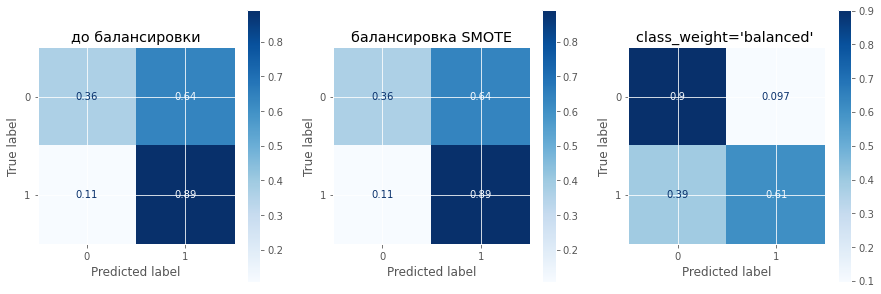

In [29]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))


confmat1=confusion_matrix(y_true=target_test,y_pred=pred_test)
print('Матрица неточностей до балансировки классов :',  confmat1)
print('До балансировки f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                                y_pred=pred_test)))
plot_confusion_matrix(estimator=rfc_classifier, X=features_test, y_true=target_test,\
                     normalize='true', cmap='Blues',ax=ax1);
ax1.set_title('до балансировки')


confmat2=confusion_matrix(y_true=target_test,y_pred=predictions_smote)
print('Матрица неточностей для SMOTE :',  confmat2)
print('SMOTE f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                                y_pred=predictions_smote)))
plot_confusion_matrix(estimator=model_smote, X=features_test, y_true=target_test,\
                     normalize='true',cmap='Blues',ax=ax2);
ax2.set_title('балансиpовка SMOTE')

predictions_test_balance = model_random_balance.fit(features_train,target_train).predict(features_test)
confmat3=confusion_matrix(y_true=target_test,y_pred=predictions_test_balance)
print('Матрица модели class_weight=balanced :',  confmat3)
print('class_weight=balanced  f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                                y_pred=predictions_test_balance)))
plot_confusion_matrix(estimator=model_random_balance, X=features_test, y_true=target_test,\
                     normalize='true', cmap='Blues',ax=ax3);
ax3.set_title("class_weight='balanced' ");

Матрица неточностей для NearMiss : [[ 724 1267]
 [  53  456]]
 NearMiss  f1  : 0.41


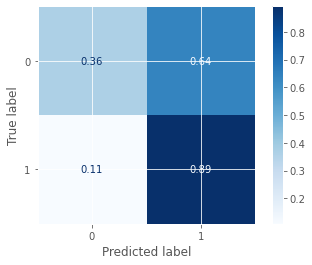

In [30]:
confmat_miss=confusion_matrix(y_true=target_test,y_pred=predictions_miss)
print('Матрица неточностей для NearMiss :',  confmat_miss)
print(' NearMiss  f1  : {:.2f}'.format(f1_score(y_true=target_test,\
                                                               y_pred=predictions_miss)))

plot_confusion_matrix(estimator=model_miss, X=features_test, y_true=target_test,\
                    normalize='true',cmap='Blues');
ax.set_title('балансировка NearMiss');


Видим что балансировка особой роли в данном случае не играет но при уменьшении дисбаланса метрика f1 падает

НО:Для способа балансировки class_weight='balanced' получили самое большое значение f1 и соответственно 
лучшее разделения по TP и TN.


Рассмотрим дополнительно бустинговую модель Catboost

АТРИБУТЫ:
best_score_ - Возвращает лучший балл модели.
classes_ - Возвращает список классов для задачи классификации.
feature_names_ — возвращает список имен компонентов.
feature_importances_ — возвращает важность каждой функции для каждого алгоритма.
learning_rate_ - Возвращает скорость обучения алгоритма.
random_seed_ — возвращает случайное семя, из которого были назначены исходные веса модели.
tree_count_ - Возвращает количество деревьев в ансамбле.
n_features_in_ — возвращает количество функций, используемых для обучения модели.
evals_result_ - Возвращает словарь оценки. Если мы предоставили оценочный набор, то результаты оценки для него будут включены.

МЕТОДИКА:
get_best_score() - Возвращает лучший балл оценщика.
get_params() - Возвращает параметры, которые были заданы в качестве словаря при создании оценщика CatBoost и их значения в виде словаря.
get_all_params() - Возвращает список всех параметров оценщика CatBoost и их значений в виде словаря.
get_cat_feature_indices() - Возвращает список индексов, который имеет категориальные признаки.
get_feature_importance() - Возвращает важность индивидуального признака в соответствии с обученной моделью.
shrink(ntree_end, ntree_start=0) - Он принимает два аргумента, которые являются конечным деревом, и начинает дерево сжимать ансамбль, чтобы включить только деревья, которые входят в этот диапазон индекса, отбрасывая все другие деревья.
set_params() - Может быть использован для задания параметров оценщика. Обратите внимание, что этот метод будет работать только перед моделью обучения.
calc_leaf_indexes(data, ntree_start=0,ntree_end=0) - Он принимает в качестве входных данных и возвращает индекс листа в каждом дереве, который использовался для прогнозирования выборки. Выходные данные этой функции будут . Он вернет индекс листьев всех деревьев для образца.n_samples x n_trees
get_leaf_values() - Возвращает фактические значения листьев деревьев в ансамбле.
get_leaf_weights() - Возвращает вес листьев для каждого листа деревьев в ансамбле.

Посмотрим работу модели без предварительной кодировки не числовых данных

In [31]:
data['geography']=data['geography'].astype('category')
data['gender']=data['gender'].astype('category')
X = data.drop(['exited'],axis=1)
y = data['exited']

X_train,X_test,y_train,y_test = train_test_split(X,y,\
                                                        test_size = 0.25,random_state = 12345,\
                                                                     stratify=y)

print('Размер тренировочной выборки',X_train.shape, y_train.shape)
print('Размер тестовой выборки',X_test.shape, y_test.shape)    # с размерностями ОК

Размер тренировочной выборки (7500, 10) (7500,)
Размер тестовой выборки (2500, 10) (2500,)


In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   creditscore      10000 non-null  int64   
 1   geography        10000 non-null  category
 2   gender           10000 non-null  category
 3   age              10000 non-null  int64   
 4   tenure           10000 non-null  float64 
 5   balance          10000 non-null  float64 
 6   numofproducts    10000 non-null  int64   
 7   hascrcard        10000 non-null  int64   
 8   isactivemember   10000 non-null  int64   
 9   estimatedsalary  10000 non-null  float64 
dtypes: category(2), float64(3), int64(5)
memory usage: 644.9 KB


Рассмотрим модель с базовами параметрами

In [33]:
booster = CatBoostClassifier(iterations=100, verbose=50, eval_metric= 'F1')
cat_features_index = [ 1, 2]
booster.fit(X_train, y_train,
            eval_set=(X_test, y_test),
            cat_features=cat_features_index,plot=True);
 
booster.set_feature_names(X_train.columns.tolist())

test_preds = booster.predict(X_test)
train_preds = booster.predict(X_train)


print("\nTest  Accuracy : %.2f"%booster.score(X_test, y_test))
print("Train Accuracy : %.2f"%booster.score(X_train, y_train))
print('Метрика f1=', f1_score(y_true=y_test,y_pred=test_preds))
print('Список всех параметров модели',booster.get_all_params())
print('Список заданных параметров',booster.get_params())


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.141922
0:	learn: 0.5151382	test: 0.5159642	best: 0.5159642 (0)	total: 336ms	remaining: 33.2s
50:	learn: 0.6004107	test: 0.5686275	best: 0.5696822 (49)	total: 3.66s	remaining: 3.52s
99:	learn: 0.6324649	test: 0.5892216	best: 0.5903614 (83)	total: 6.74s	remaining: 0us

bestTest = 0.5903614458
bestIteration = 83

Shrink model to first 84 iterations.

Test  Accuracy : 0.86
Train Accuracy : 0.88
Метрика f1= 0.5903614457831324
Список всех параметров модели {'nan_mode': 'Min', 'eval_metric': 'F1', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 100, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constan

In [34]:
booster.get_feature_importance(prettified=True)

,Feature Id,Importances
0,numofproducts,29.981378
1,age,24.357159
2,balance,12.480874
3,isactivemember,10.670877
4,geography,10.664145
5,estimatedsalary,3.244338
6,gender,3.037913
7,creditscore,2.643570
8,tenure,2.496055
9,hascrcard,0.423691


In [35]:
booster = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
booster.fit(
    X_train, y_train,
    cat_features=cat_features_index,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [36]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features_index)
curve = get_roc_curve(booster, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

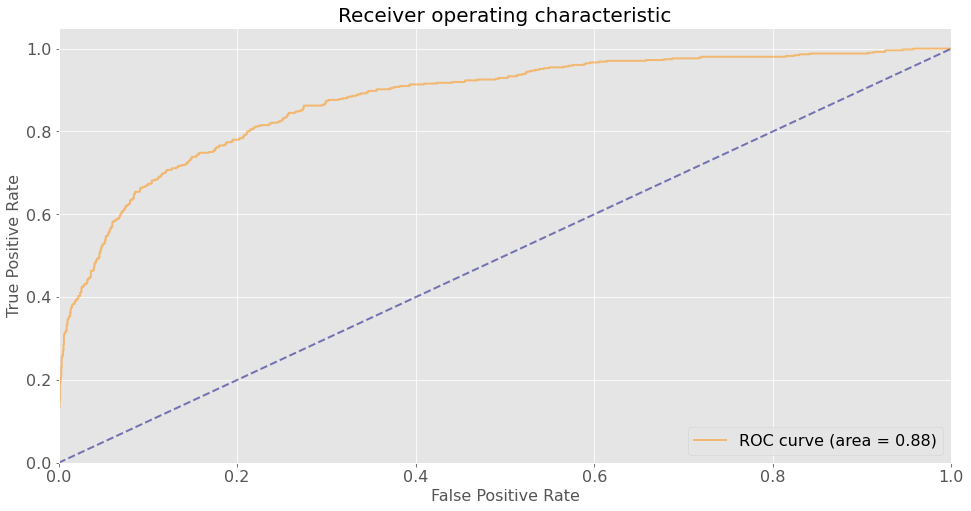

In [37]:


plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [38]:

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

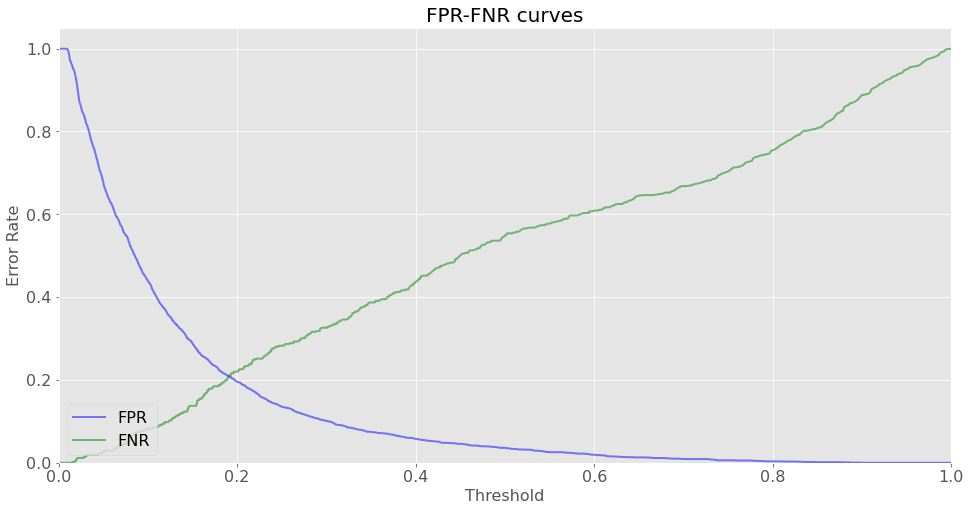

In [39]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [40]:
# порог для заданных долей FN FP
from catboost.utils import select_threshold
print(select_threshold(model=booster, data=eval_pool, FNR=0.01))
print(select_threshold(model=booster, data=eval_pool, FPR=0.01))


0.02099891094871441
0.696046838942124


Потренируем модель на скорость и определим параметры для быстрой минимизации функции потерь

In [41]:
# определяем скорость обучения для параметров
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.1,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.25,
    one_hot_max_size=25,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features_index,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [42]:
tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features_index,
    verbose=False,
    eval_set=(X_test, y_test),
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Подберем гиперпараметры и найдем лучшую модель

In [43]:
model = CatBoostClassifier(eval_metric= 'F1')

params = {
            'iterations':[50,100,150],
            'learning_rate':[0.01, 0.1, 0.5],
            'bootstrap_type':['Bayesian', 'No']}
            
search_results = model.grid_search(params, features_train, target_train,cv=5,stratified=True,verbose=0)



0:	learn: 0.4400738	test: 0.4150943	best: 0.4150943 (0)	total: 16.2ms	remaining: 792ms
1:	learn: 0.4931507	test: 0.4568966	best: 0.4568966 (1)	total: 23.7ms	remaining: 568ms
2:	learn: 0.5266667	test: 0.5150215	best: 0.5150215 (2)	total: 30.4ms	remaining: 477ms
3:	learn: 0.5166010	test: 0.5086207	best: 0.5150215 (2)	total: 37.9ms	remaining: 436ms
4:	learn: 0.5135747	test: 0.5032538	best: 0.5150215 (2)	total: 78ms	remaining: 702ms
5:	learn: 0.5099602	test: 0.5075922	best: 0.5150215 (2)	total: 89.7ms	remaining: 658ms
6:	learn: 0.5194366	test: 0.5119306	best: 0.5150215 (2)	total: 99.1ms	remaining: 609ms
7:	learn: 0.5155455	test: 0.5076586	best: 0.5150215 (2)	total: 110ms	remaining: 576ms
8:	learn: 0.5065752	test: 0.5076586	best: 0.5150215 (2)	total: 117ms	remaining: 533ms
9:	learn: 0.5091324	test: 0.5043860	best: 0.5150215 (2)	total: 125ms	remaining: 498ms
10:	learn: 0.5127623	test: 0.5076586	best: 0.5150215 (2)	total: 133ms	remaining: 471ms
11:	learn: 0.5104935	test: 0.5076586	best: 0.515

In [44]:

model.fit(features_train, target_train,
           eval_set=(features_test, target_test),
            plot=True);
model.set_feature_names(features_train.columns.tolist()) 

test_preds = model.predict(features_test)
train_preds = model.predict(features_train)

print("\nTest  Accuracy : %.2f"%model.score(features_test, target_test))
print("Train Accuracy : %.2f"%model.score(features_train, target_train))
print('Метрика f1=', f1_score(y_true=target_test,y_pred=test_preds))
print(classification_report(target_test,test_preds ))
print("\nЛучшие выбранные параметры : ", search_results['params'])

print("Параметры заданные при создании модели : ",model.get_params())
print("\nВсе возможные параметры этой модели : ",model.get_all_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5192781	test: 0.5782557	best: 0.5782557 (0)	total: 7.57ms	remaining: 371ms
1:	learn: 0.5132042	test: 0.5268542	best: 0.5782557 (0)	total: 18.8ms	remaining: 451ms
2:	learn: 0.5322227	test: 0.5377721	best: 0.5782557 (0)	total: 26.5ms	remaining: 415ms
3:	learn: 0.5488851	test: 0.5568040	best: 0.5782557 (0)	total: 46.3ms	remaining: 532ms
4:	learn: 0.5448246	test: 0.5573770	best: 0.5782557 (0)	total: 54.9ms	remaining: 494ms
5:	learn: 0.5709488	test: 0.5668317	best: 0.5782557 (0)	total: 62.3ms	remaining: 457ms
6:	learn: 0.5753425	test: 0.5717791	best: 0.5782557 (0)	total: 73ms	remaining: 448ms
7:	learn: 0.5739348	test: 0.5647349	best: 0.5782557 (0)	total: 80.8ms	remaining: 424ms
8:	learn: 0.5768104	test: 0.5640394	best: 0.5782557 (0)	total: 110ms	remaining: 503ms
9:	learn: 0.5890128	test: 0.5819071	best: 0.5819071 (9)	total: 117ms	remaining: 469ms
10:	learn: 0.5902721	test: 0.5804878	best: 0.5819071 (9)	total: 126ms	remaining: 448ms
11:	learn: 0.5966490	test: 0.5940120	best: 0.59

In [45]:
# определили лучшие параметры
cv_results = pd.DataFrame(search_results["cv_results"])
cv_results.head()

,iterations,test-F1-mean,test-F1-std,train-F1-mean,train-F1-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.483099,0.046332,0.488307,0.030922,0.442449,0.017510,0.439946,0.013939
1,1,0.534218,0.036090,0.533396,0.004064,0.377240,0.012360,0.373086,0.006157
2,2,0.537505,0.024992,0.548029,0.007814,0.358244,0.010481,0.350720,0.002444
3,3,0.545417,0.033198,0.560622,0.005002,0.350889,0.012076,0.341062,0.003950
4,4,0.558221,0.027602,0.577509,0.008119,0.343791,0.009043,0.330807,0.001158


Матрица ошибок модели [[5788.  184.]
 [ 721.  807.]]


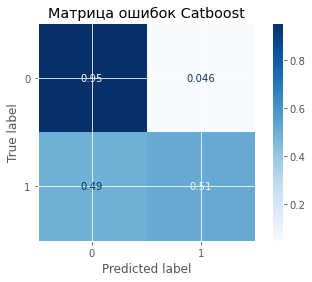

In [46]:
cm = get_confusion_matrix(model, Pool(features_train, target_train))
print('Матрица ошибок модели',cm)
plot_confusion_matrix(estimator=model, X=features_test, y_true=target_test,\
                    normalize='true',cmap='Blues');
plt.title('Матрица ошибок Catboost');

Результат очень хороший для TN меток в нашем случае класс 0.

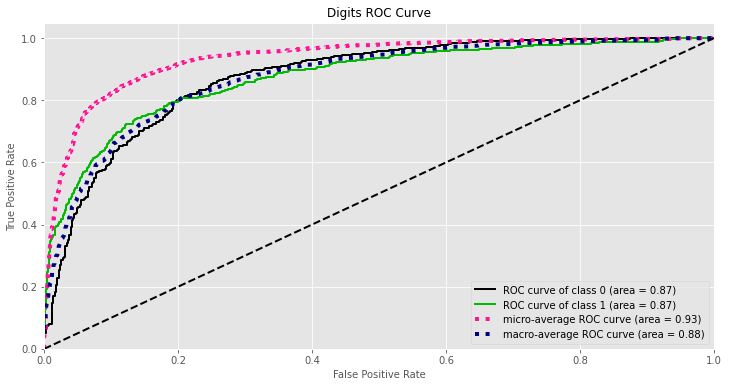

In [47]:
lr_probs = model.predict_proba(features_test)

skplt.metrics.plot_roc_curve(target_test, lr_probs,
                       title="Digits ROC Curve", figsize=(12,6));

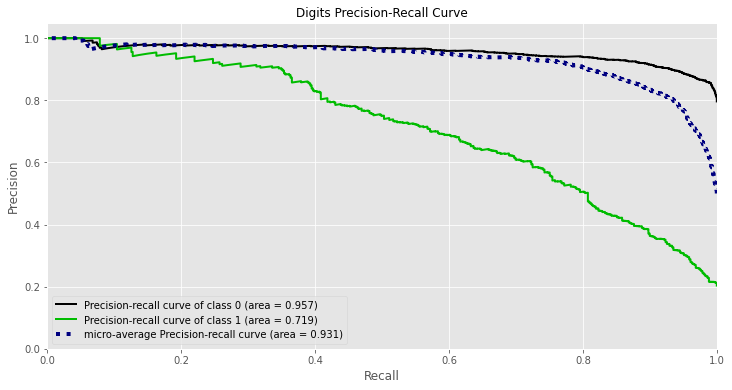

In [48]:
skplt.metrics.plot_precision_recall_curve(target_test, lr_probs,
                       title="Digits Precision-Recall Curve", figsize=(12,6));

Статистика КС (статистика Колмогорова-Смирнова) представляет собой максимальную разницу между кумулятивной истинно-положительной и кумулятивной ложноположительной скоростью. Он отражает способность модели отличать положительные ярлыки от отрицательных. График статистики KS предназначен только для задач двоичной классификации.
Мы впервые обучили случайный лесной классификатор на данных. Затем мы передали оригинальные метки тестов и предсказали вероятности тестирования с помощью модели случайного обучения леса, чтобы построить диаграмму статистики KS.plot_ks_statistic()

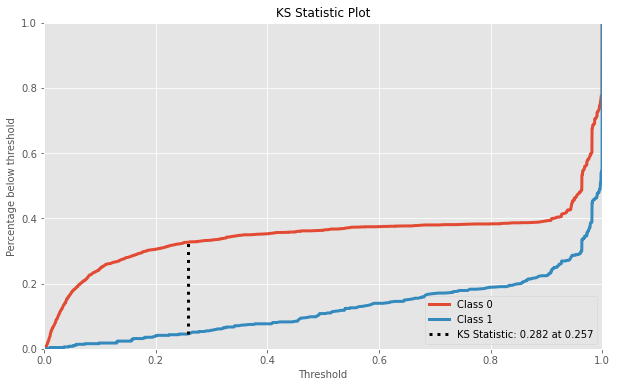

In [49]:
predict_probas = rfc_classifier.predict_proba(features_test)
skplt.metrics.plot_ks_statistic(target_test, predict_probas, figsize=(10,6));

Диаграмма кумулятивного прироста говорит нам о проценте выборок в данной категории, которые были действительно предсказаны путем таргетинга на процент от общего числа выборок. Это означает, что когда мы взяли, что многие проценты выборок из общего процента, который мы получаем от кривой для оси Y, являются метками, которые действительно были угаданы моделью из общего числа образцов этого класса в таком количестве выборок. Пунктирная линия на графике является базовой кривой (модель случайного угадывания), и наша модель должна работать лучше, чем она, и обе кривые класса должны быть выше нее в идеале. Кумулятивная кривая прибыли предназначена только для задач двоичной классификации.

Нам нужно передать исходные метки данных и предсказанные вероятности обученной моделью, чтобы построить кумулятивную кривую прибыли

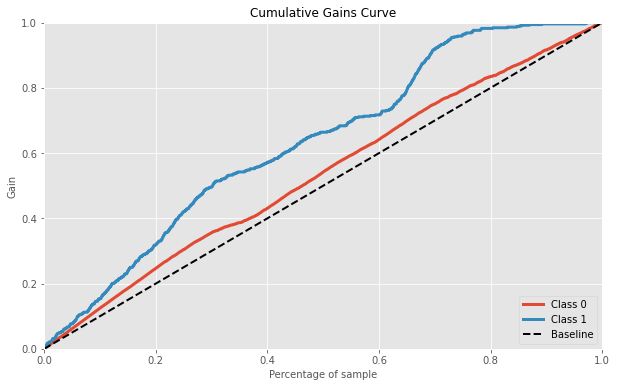

In [50]:
skplt.metrics.plot_cumulative_gain(target_test, predict_probas, figsize=(10,6));

Диаграмма точности прогнозов выводится из кумулятивной диаграммы путем взятия отношения кумулятивного прироста для каждой кривой к базовому уровню и отображения этого соотношения на оси Y. Ось X имеет то же значение, что и приведенная выше диаграмма. Кривая подъема предназначена только для задач двоичной классификации.

Нам нужно передать его исходные метки данных и предсказанные вероятности обученной моделью, чтобы построить кривую подъема

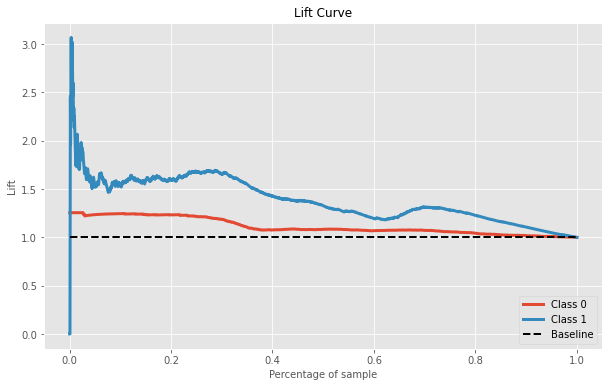

In [51]:
skplt.metrics.plot_lift_curve(target_test, predict_probas, figsize=(10,6));

0:	learn: 0.5192781	total: 7.71ms	remaining: 378ms
1:	learn: 0.5132042	total: 15.5ms	remaining: 373ms
2:	learn: 0.5322227	total: 21.9ms	remaining: 344ms
3:	learn: 0.5488851	total: 29.7ms	remaining: 342ms
4:	learn: 0.5448246	total: 39.5ms	remaining: 355ms
5:	learn: 0.5709488	total: 46.6ms	remaining: 342ms
6:	learn: 0.5753425	total: 56ms	remaining: 344ms
7:	learn: 0.5739348	total: 64.3ms	remaining: 338ms
8:	learn: 0.5768104	total: 72.8ms	remaining: 332ms
9:	learn: 0.5890128	total: 83.7ms	remaining: 335ms
10:	learn: 0.5902721	total: 92.6ms	remaining: 328ms
11:	learn: 0.5966490	total: 101ms	remaining: 321ms
12:	learn: 0.5959885	total: 112ms	remaining: 320ms
13:	learn: 0.6023510	total: 120ms	remaining: 308ms
14:	learn: 0.6045381	total: 129ms	remaining: 302ms
15:	learn: 0.6041245	total: 137ms	remaining: 291ms
16:	learn: 0.6049333	total: 147ms	remaining: 286ms
17:	learn: 0.6063787	total: 154ms	remaining: 273ms
18:	learn: 0.6079224	total: 165ms	remaining: 269ms
19:	learn: 0.6166263	total: 174m

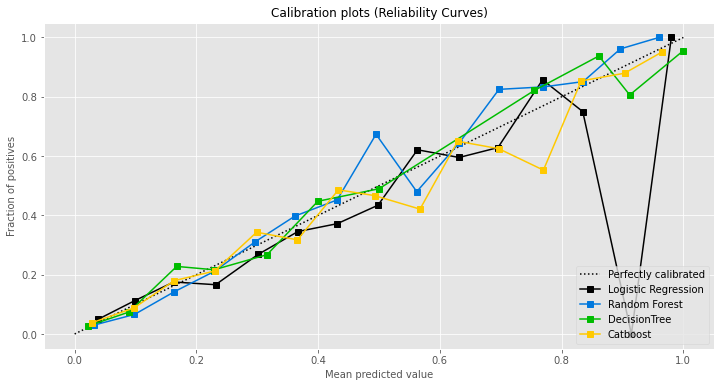

In [52]:
lr_probas = lgr_classifier.fit(features_train, target_train).predict_proba(features_test)
rf_probas = rfc_classifier.fit(features_train, target_train).predict_proba(features_test)
dt_probas = dtr_classifier.fit(features_train, target_train).predict_proba(features_test)
cbc_probas= model.fit(features_train, target_train).predict_proba(features_test)
probas_list = [lr_probas, rf_probas,dt_probas,cbc_probas]
clf_names = ['Logistic Regression', 'Random Forest', 'DecisionTree','Catboost']
skplt.metrics.plot_calibration_curve(target_test,
                                     probas_list,
                                     clf_names, n_bins=15,
                                     figsize=(12,6)
                                     );

Кроме логистической модели все остальные хорошо отработали по классам 